<font size=3 color='orange'>Machine Failure Prediction

Imporitng Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rcParams['patch.force_edgecolor']=True
import seaborn as sns
sns.set_style('whitegrid')
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Activation,Dropout
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from itertools import combinations
import os
import datetime
import collections
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TerminateOnNaN
from tensorflow.keras.callbacks import EarlyStopping
%load_ext tensorboard

In [2]:
!curl --header 'Host: doc-10-a0-docs.googleusercontent.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:94.0) Gecko/20100101 Firefox/94.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --header 'DNT: 1' --cookie 'AUTH_9n4dq44hooaaslh20mjnd8bj0rv6432e=18252328693629936117|1638319950000|ak3i1ghbdgkev1j55o588mv2j45t3qe5' --header 'Upgrade-Insecure-Requests: 1' --header 'Sec-Fetch-Dest: iframe' --header 'Sec-Fetch-Mode: navigate' --header 'Sec-Fetch-Site: cross-site' 'https://doc-10-a0-docs.googleusercontent.com/docs/securesc/b6f3i9sti2iqtqc852seut3vphbmj2k0/6u5ev5vcknabfgg3poc2kkoe7ldl186a/1638320025000/18252328693629936117/18252328693629936117/1fahHuxncmLsOkrlI7bpFCReIQBZScnmV?e=download&authuser=0' --output 'Cleaned_data.csv'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7693k  100 7693k    0     0  16.9M      0 --:--:-- --:--:-- --:--:-- 16.8M


In [3]:
data = pd.read_csv('Cleaned_data.csv')
data.head()

,Leakage,Parameter1_Dir,Parameter1_Speed,Parameter2_9am,Parameter2_3pm,Failure_today,RISK_MM,Fail_tomorrow,parameter4,parameter5,parameter7,date
0,0.6,W,44.0,W,WNW,0,0.0,0,93.0,2014.8,38.7,2008
1,0.0,WNW,44.0,NNW,WSW,0,0.0,0,69.0,2018.4,41.5,2008
2,0.0,WSW,46.0,W,WSW,0,0.0,0,68.0,2016.3,44.2,2008
3,0.0,NE,24.0,SE,E,0,1.0,0,61.0,2030.4,44.6,2008
4,1.0,W,41.0,ENE,NW,0,0.2,0,115.0,2016.8,47.5,2008


In [4]:
print("total data points in the data are:", data.shape[0])
print("total columns in the data are:", data.shape[1])

total data points in the data are: 142193
total columns in the data are: 12


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Leakage           142193 non-null  float64
 1   Parameter1_Dir    142193 non-null  object 
 2   Parameter1_Speed  142193 non-null  float64
 3   Parameter2_9am    142193 non-null  object 
 4   Parameter2_3pm    142193 non-null  object 
 5   Failure_today     142193 non-null  int64  
 6   RISK_MM           142193 non-null  float64
 7   Fail_tomorrow     142193 non-null  int64  
 8   parameter4        142193 non-null  float64
 9   parameter5        142193 non-null  float64
 10  parameter7        142193 non-null  float64
 11  date              142193 non-null  int64  
dtypes: float64(6), int64(3), object(3)
memory usage: 13.0+ MB


<font size=2 color='blue'>Splitting into Train adn Test

Since we have time axis we'll split the data using temporal splitting instead of random splitting

In [6]:
#sorting the data
data.sort_values(by=['date'], inplace=True)

In [7]:
x = data.drop(['Fail_tomorrow','date'], axis=1)
y = data['Fail_tomorrow'].values

In [8]:
#spltting 70% into train and 30% into test
split_index = int(len(x)*0.7)
X_train = x[0:split_index]
X_test = x[split_index:]
y_train = y[0:split_index]
y_test = y[split_index:]

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (99535, 10)
y_train:  (99535,)
X_test:  (42658, 10)
y_test:  (42658,)


<font size=2 color='blue'>Converting Catgeorical to Numerical Features

In [9]:
vectorizer = CountVectorizer()

vectorizer.fit(X_train['Parameter1_Dir'].values)
X_train_param1 = vectorizer.transform(X_train['Parameter1_Dir'].values)
X_test_param1 = vectorizer.transform(X_test['Parameter1_Dir'].values)

vectorizer.fit(X_train['Parameter2_9am'].values)
X_train_param29am = vectorizer.transform(X_train['Parameter2_9am'].values)
X_test_param29am = vectorizer.transform(X_test['Parameter2_9am'].values)

vectorizer.fit(X_train['Parameter2_3pm'].values)
X_train_param23pm = vectorizer.transform(X_train['Parameter2_3pm'].values)
X_test_param23pm = vectorizer.transform(X_test['Parameter2_3pm'].values)

Normalizing Numerical Features

In [10]:
normalizer = Normalizer()

X_train_Leakage = normalizer.fit_transform(X_train['Leakage'].values.reshape(1,-1)).T
X_test_Leakage = normalizer.fit_transform(X_test['Leakage'].values.reshape(1,-1)).T

X_train_param1_speed = normalizer.fit_transform(X_train['Parameter1_Speed'].values.reshape(1,-1)).T
X_test_param1_speed = normalizer.fit_transform(X_test['Parameter1_Speed'].values.reshape(1,-1)).T

X_train_fail = normalizer.fit_transform(X_train['Failure_today'].values.reshape(1,-1)).T
X_test_fail = normalizer.fit_transform(X_test['Failure_today'].values.reshape(1,-1)).T

X_train_risk = normalizer.fit_transform(X_train['RISK_MM'].values.reshape(1,-1)).T
X_test_risk = normalizer.fit_transform(X_test['RISK_MM'].values.reshape(1,-1)).T

X_train_param4 = normalizer.fit_transform(X_train['parameter4'].values.reshape(1,-1)).T
X_test_param4 = normalizer.fit_transform(X_test['parameter4'].values.reshape(1,-1)).T

X_train_param5 = normalizer.fit_transform(X_train['parameter5'].values.reshape(1,-1)).T
X_test_param5 = normalizer.fit_transform(X_test['parameter5'].values.reshape(1,-1)).T

X_train_param7 = normalizer.fit_transform(X_train['parameter7'].values.reshape(1,-1)).T
X_test_param7 = normalizer.fit_transform(X_test['parameter7'].values.reshape(1,-1)).T

Concatinating all features

In [11]:
X_tr = hstack((X_train_param1, X_train_param29am, X_train_param23pm, X_train_Leakage, X_train_param1_speed, X_train_fail, X_train_risk, X_train_param4, X_train_param5, X_train_param7)).toarray()
X_te = hstack((X_test_param1, X_test_param29am, X_test_param23pm, X_test_Leakage, X_test_param1_speed, X_test_fail, X_test_risk, X_test_param4, X_test_param5, X_test_param7)).toarray()

<font size=2 color='blue'>Building the model

1. Logistic Regression

f1: 0.40587580439327703
AUC: 0.35288960111939494
0.48705987153640584


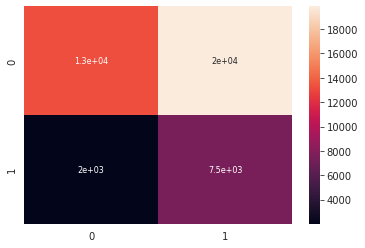

In [12]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss='log', class_weight='balanced', random_state=42)
sgd.fit(X_tr, y_train)

y_pred = sgd.predict(X_te)
f1 = f1_score(y_test, y_pred)
print("f1:", f1)

auc = roc_auc_score(y_test, sgd.predict_proba(X_te)[:,0])
print('AUC:', auc)

print(sgd.score(X_te, y_test))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True,  annot_kws={"fontsize":8})

Custom Callbacks

In [13]:
#Decaying Learning rate using epoch
def changeLearningRate(epoch, lr):
    if (epoch+1)%3==0:
        return lr*0.95
    else:
        return lr
lrschedule = LearningRateScheduler(changeLearningRate, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=1, min_lr=0.001)

loss_terminate = TerminateOnNaN()

class TerminateNaN(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        mod_weights = model.get_weights()
        if mod_weights is not None:
            if np.any([np.any(np.isnan(x)) for x in mod_weights]):
                print("Invalid weight and terminated at epoch {}".format(epoch))
                self.model.stop_training = True
weight_terminate = TerminateNaN()

earlystop = EarlyStopping(monitor='val_accuracy', patience=2)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 43)]              0         
                                                                 
 dense_24 (Dense)            (None, 256)               11264     
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 128)               32896     
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 64)                8256      
                                                                 
 dropout_18 (Dropout)        (None, 64)                0   

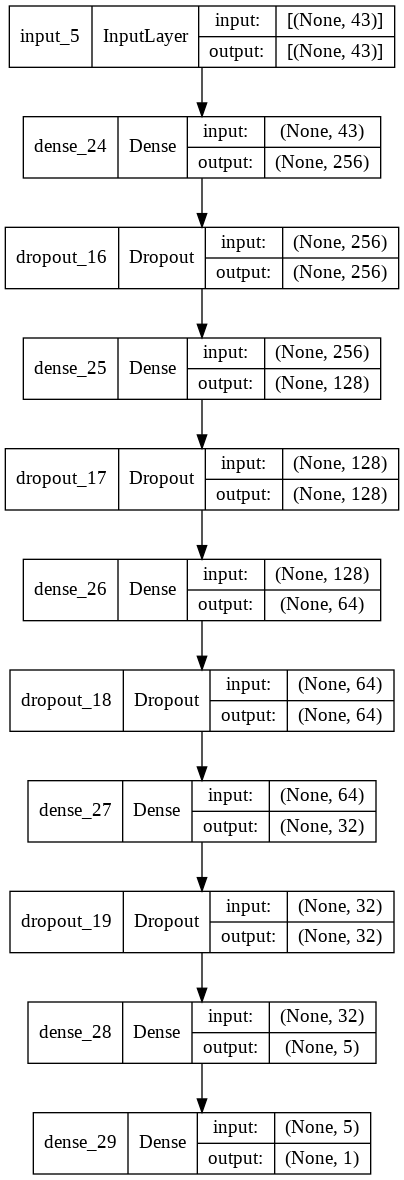

In [27]:
#Input 
input_layer = Input(shape=(43,))

#Dense hidden layer1
layer1 = Dense(256,activation='relu',kernel_initializer=initializers.HeNormal(seed=30))(input_layer)
dropout = Dropout(0.2)(layer1)

#Dense hidden layer2
layer2 = Dense(128,activation='relu',kernel_initializer=initializers.HeNormal(seed=30))(dropout)
dropout = Dropout(0.2)(layer2)

#Dense hidden layer3
layer3 = Dense(64,activation='relu',kernel_initializer=initializers.HeNormal(seed=30))(dropout)
dropout = Dropout(0.2)(layer3)

#Dense hidden layer4
layer4 = Dense(32,activation='relu',kernel_initializer=initializers.HeNormal(seed=30))(dropout)
dropout = Dropout(0.2)(layer4)

#Dense hidden layer5
layer5 = Dense(5,activation='relu',kernel_initializer=initializers.HeNormal(seed=30))(dropout)

#output layer
output = Dense(1,activation='sigmoid',kernel_initializer=initializers.HeNormal(seed=30))(layer5)

#Creating a model
model = Model(inputs=input_layer,outputs=output)     

callbacks = [lrschedule, reduce_lr, weight_terminate, loss_terminate, earlystop]

print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

In [28]:
#optimizer
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_tr,y_train,epochs=20, validation_data=(X_te,y_test), batch_size=16, callbacks=callbacks)


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
6221/6221 [==============================] - 34s 5ms/step - loss: 0.5179 - accuracy: 0.7763 - val_loss: 0.4289 - val_accuracy: 0.8202 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/20
6221/6221 [==============================] - 33s 5ms/step - loss: 0.4131 - accuracy: 0.8269 - val_loss: 0.3384 - val_accuracy: 0.8492 - lr: 0.0010

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009500000451225787.
Epoch 3/20
6221/6221 [==============================] - 37s 6ms/step - loss: 0.3117 - accuracy: 0.8776 - val_loss: 0.2707 - val_accuracy: 0.8869 - lr: 9.5000e-04

Epoch 00004: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 4/20
6221/6221 [==============================] - 33s 5ms/step - loss: 0.2033 - accuracy: 0.9238 - val_loss: 0.2226 - val_accuracy: 0.9147 - lr: 9.5000e-04

Epoch 00005: LearningRa